In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from itertools import product
import statsmodels.api as sm
from PortfolioAnalysis import *

from DataPipeline import DataPipeline, MSE, R2, r2_metrics

file_path = '/Users/zequnli/LocalData/'

2023-10-11 11:34:27.379872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data
dataset = DataPipeline(file_path)

In [3]:
train_mask = ((dataset.data['yyyymm']>196400)&(dataset.data['yyyymm'] < 197500))
validation_mask = (dataset.data['yyyymm'] >= 197500) & (dataset.data['yyyymm'] < 198900)
test_mask = (dataset.data['yyyymm'] > 198900)

# Naive Model

In [4]:
N = dataset.data.shape[0]

In [5]:
dataset.result = dataset.result.assign(pred_naive = np.zeros(N))
dataset.result.head()

,yyyymm,permno,exret,me,pred_naive
0,196307,10006,-4.786129,134.40250,0.0
1,196307,10014,-0.270000,11.11725,0.0
2,196307,10030,-6.633636,83.73900,0.0
3,196307,10057,-9.674990,29.25000,0.0
4,196307,10065,1.172308,90.83550,0.0


In [6]:
print('Naive Model')
print('Training MSE: ', MSE(dataset.result[train_mask]['exret'], dataset.result[train_mask]['pred_naive']))
print('Training R2: ', R2(dataset.result[train_mask]['exret'], dataset.result[train_mask]['pred_naive']))
print('Validation MSE: ', MSE(dataset.result[validation_mask]['exret'], dataset.result[validation_mask]['pred_naive']))
print('Validation R2: ', R2(dataset.result[validation_mask]['exret'], dataset.result[validation_mask]['pred_naive']))
print('Testing MSE: ', MSE(dataset.result[test_mask]['exret'], dataset.result[test_mask]['pred_naive']))
print('Testing R2: ', R2(dataset.result[test_mask]['exret'], dataset.result[test_mask]['pred_naive']))


Naive Model
Training MSE:  178.69111790342325
Training R2:  0.0
Validation MSE:  269.9448932916952
Validation R2:  0.0
Testing MSE:  344.6284089110785
Testing R2:  0.0


# Fama-Macbeth Regression

In [7]:
params = {}
result_insample = []
for year,month in product(range(1963,2022),range(1,13)):
    if year == 1963 and month < 7:
        continue
    X,Y, _ = dataset.LoadOneMonthXY(year,month)
    X = sm.add_constant(X)
    lr = sm.OLS(Y,X).fit()
    params[year*100+month] = lr.params
    result_insample.extend(lr.predict(X))
#params = pd.DataFrame(params).T

In [8]:
params = pd.DataFrame(params).T
params.head()

,const,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,mom6m,...,sp,tang,tb,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
196307,-0.699169,-4.689051,159.213833,-159.950747,-2.824086,-2.671773,0.215054,0.665171,-1.231144,3.493258,...,-0.094346,-0.032077,0.441298,-0.386946,-7.586753,-0.882051,2.121411,0.660516,0.972391,0.427900
196308,3.744367,2.409429,2.596375,-1.236768,0.805640,-2.054701,0.102103,-0.073179,-1.493755,-0.792728,...,0.373587,-1.032377,0.790753,0.949044,-2.403421,1.398303,-0.799424,-0.269395,0.404065,0.829455
196309,-1.667693,-2.187316,0.591948,-1.135714,-2.240378,0.193290,0.131997,-0.830155,-0.642869,2.700866,...,0.886307,0.278517,-0.581983,-0.049910,0.729494,-0.198009,-0.398638,0.232616,0.309967,-0.280502
196310,0.804204,-0.084068,3.260203,-2.408883,2.249495,-3.475745,-0.659500,-0.043274,-1.356009,-1.731531,...,3.184287,-0.354145,-1.228431,0.516128,-2.394858,-0.224880,-0.009463,-0.469111,-0.784682,-0.664575
196311,-1.987795,-0.516194,0.681784,-1.720666,-0.048361,-1.269061,-1.220269,-0.781862,-1.179323,-1.222799,...,-1.022035,1.049448,0.189442,0.617172,-2.047514,-1.507139,0.265561,0.647448,-1.305455,-0.331472


In [9]:
dataset.result = dataset.result.assign(pred_fm_insample = result_insample)
dataset.result.head()

,yyyymm,permno,exret,me,pred_naive,pred_fm_insample
0,196307,10006,-4.786129,134.40250,0.0,0.939823
1,196307,10014,-0.270000,11.11725,0.0,-0.999193
2,196307,10030,-6.633636,83.73900,0.0,-3.975940
3,196307,10057,-9.674990,29.25000,0.0,0.329819
4,196307,10065,1.172308,90.83550,0.0,-1.657534


In [10]:
result_oos = []
for year,month in product(range(1963,2022),range(1,13)):
    X,Y, month_result = dataset.LoadOneMonthXY(year,month)
    if year < 1975:
        result_oos.extend(np.zeros(X.shape[0]))
        continue
    X = sm.add_constant(X)
    param = params.rolling(12).mean().shift().loc[year*100+month]
    result_oos.extend(X.dot(param))

dataset.result = dataset.result.assign(pred_fm_oos = result_oos)

In [11]:
dataset.result.head()

,yyyymm,permno,exret,me,pred_naive,pred_fm_insample,pred_fm_oos
0,196307,10006,-4.786129,134.40250,0.0,0.939823,0.0
1,196307,10014,-0.270000,11.11725,0.0,-0.999193,0.0
2,196307,10030,-6.633636,83.73900,0.0,-3.975940,0.0
3,196307,10057,-9.674990,29.25000,0.0,0.329819,0.0
4,196307,10065,1.172308,90.83550,0.0,-1.657534,0.0


In [12]:
print('FM Regression')
print('Training MSE: ', MSE(dataset.result[train_mask]['exret'], dataset.result[train_mask]['pred_fm_insample']))
print('Training R2: ', R2(dataset.result[train_mask]['exret'], dataset.result[train_mask]['pred_fm_insample']))
print('Validation MSE: ', MSE(dataset.result[validation_mask]['exret'], dataset.result[validation_mask]['pred_fm_oos']))
print('Validation R2: ', R2(dataset.result[validation_mask]['exret'], dataset.result[validation_mask]['pred_fm_oos']))
print('Testing MSE: ', MSE(dataset.result[test_mask]['exret'], dataset.result[test_mask]['pred_fm_oos']))
print('Testing R2: ', R2(dataset.result[test_mask]['exret'], dataset.result[test_mask]['pred_fm_oos']))

FM Regression
Training MSE:  119.03600544199311
Training R2:  0.33384486683703996
Validation MSE:  478.7133360918769
Validation R2:  -0.7733742996745343
Testing MSE:  348.1440041731067
Testing R2:  -0.010201118570394074


In [13]:
fm_test = dataset.result[test_mask][['yyyymm','permno','exret','me','pred_fm_oos']]
# make yyyymm as datetime
fm_test['yyyymm'] = pd.to_datetime(fm_test['yyyymm'], format='%Y%m')
fm_test.head()
# for each yyyymm, form 5 portfolios based on pred_fm
fm_test['portfolio'] = fm_test.groupby('yyyymm')['pred_fm_oos'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
fm_test.head()

,yyyymm,permno,exret,me,pred_fm_oos,portfolio
1319006,1989-01-01,10001,1.410784,6.487000,2.247227,4
1319007,1989-01-01,10002,5.420149,10.428125,2.241160,4
1319008,1989-01-01,10003,-4.497368,40.040500,1.779155,3
1319009,1989-01-01,10005,-0.550000,0.785250,-1.780022,0
1319010,1989-01-01,10009,-1.661111,10.351000,3.067769,4


In [14]:
# calculate average return for each portfolio
fm_portfolio = fm_test.groupby(['yyyymm','portfolio'])['exret'].mean().reset_index()
fm_portfolio = fm_portfolio.pivot(index='yyyymm', columns='portfolio', values='exret')
fm_portfolio.head()

portfolio,0,1,2,3,4
yyyymm,,,,,
1989-01-01,4.653314,4.072377,5.421194,5.422270,8.435011
1989-02-01,-1.491355,-0.747164,-0.764893,0.162643,1.400612
1989-03-01,0.482401,1.110092,0.828719,1.729592,1.262335
1989-04-01,-0.388324,2.545135,2.387296,2.626478,3.932036
1989-05-01,-0.453253,1.987970,2.380917,2.035178,2.394380


<AxesSubplot: title={'center': 'Cumulative Portfolio Return of NN3 Model'}, xlabel='yyyymm'>

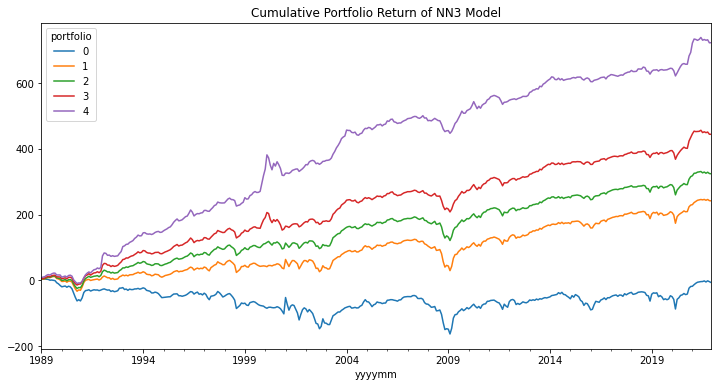

In [15]:
# plot the cumsum of the 5 portfolios
fm_portfolio.cumsum().plot(figsize=(12,6), title='Cumulative Portfolio Return of NN3 Model')

In [16]:
apply_newey_west_t_stat(fm_portfolio.fillna(0)).round(3)

portfolio,0,1,2,3,4
Mean,-0.017,0.611,0.819,1.122,1.827
Standard Error,0.338,0.266,0.241,0.275,0.381
T-statistic,-0.050,2.297,3.403,4.081,4.791
P-value,0.960,0.022,0.001,0.000,0.000
SR,-0.008,0.380,0.576,0.764,0.956


# NN3 model

In [17]:
from tensorflow.keras.models import load_model

In [18]:
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load_model(file_path+'NN3_model/NN3_'+str(year)+'.keras', custom_objects={'r2_metrics': r2_metrics})
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

2023-10-11 11:36:37.649011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2440/2440 [==============================] - 2s 661us/step


In [19]:
model = load_model(file_path+'NN3_model/NN3_1989.keras', custom_objects={'r2_metrics': r2_metrics})
X_train = dataset.data[train_mask][dataset.features]
y_train = dataset.data[train_mask]['exret']
y_train_pred = model.predict(X_train)

X_validation = dataset.data[validation_mask][dataset.features]
y_validation = dataset.data[validation_mask]['exret']
y_validation_pred = model.predict(X_validation)

29276/29276 [==============================] - 20s 685us/step


In [20]:
print('Training MSE: ',MSE(y_train, y_train_pred))
print('Training R2: ', R2(y_train, y_train_pred))
print('Validation MSE: ',MSE(y_validation, y_validation_pred))
print('Validation R2: ', R2(y_validation, y_validation_pred))
print('Testing MSE: ',MSE(y_test, y_pred))
print('Testing R2: ', R2(y_test, y_pred))

Training MSE:  177.7227371207504
Training R2:  0.005419300041517583
Validation MSE:  266.88295948767694
Validation R2:  0.011342810625832533
Testing MSE:  342.95523570576665
Testing R2:  0.004855006615962387


In [21]:
# concat y_train_pred, y_validation_pred, y_pred into one list
# y_pred = np.concatenate((y_train_pred, y_validation_pred, y_pred), axis=0)
nn_test = dataset.data[test_mask]
nn_test = nn_test.assign(pred_nn = np.array(y_pred).reshape(-1))
nn_test = nn_test[['yyyymm','permno','exret','me','pred_nn']]
# make yyyymm as datetime
nn_test['yyyymm'] = pd.to_datetime(nn_test['yyyymm'], format='%Y%m')
nn_test.head()
# for each yyyymm, form 5 portfolios based on pred_nn
nn_test['portfolio'] = nn_test.groupby('yyyymm')['pred_nn'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
nn_test.head()

,yyyymm,permno,exret,me,pred_nn,portfolio
1319006,1989-01-01,10001,1.410784,6.487000,0.790161,3
1319007,1989-01-01,10002,5.420149,10.428125,0.353746,1
1319008,1989-01-01,10003,-4.497368,40.040500,0.593687,2
1319009,1989-01-01,10005,-0.550000,0.785250,0.078737,0
1319010,1989-01-01,10009,-1.661111,10.351000,0.941164,3


In [22]:
# calculate average return for each portfolio
nn_portfolio = nn_test.groupby(['yyyymm','portfolio'])['exret'].mean().reset_index()
nn_portfolio = nn_portfolio.pivot(index='yyyymm', columns='portfolio', values='exret')
nn_portfolio.head()

portfolio,0,1,2,3,4
yyyymm,,,,,
1989-01-01,4.145310,4.721691,4.698342,4.659125,9.779090
1989-02-01,-2.087991,-0.217970,-0.419250,-0.048848,1.334155
1989-03-01,-0.053966,0.837910,0.987194,1.758369,1.883455
1989-04-01,-0.167648,1.712057,3.364655,3.001365,3.192908
1989-05-01,0.195628,1.285162,2.434858,2.120669,2.308461


<AxesSubplot: title={'center': 'Cumulative Portfolio Return of NN3 Model'}, xlabel='yyyymm'>

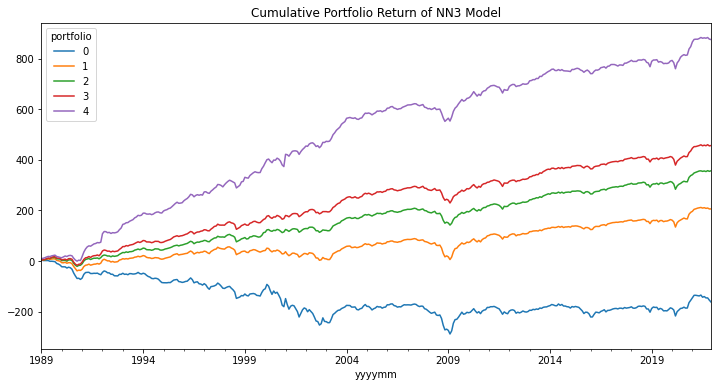

In [23]:
# plot the cumsum of the 5 portfolios
nn_portfolio.cumsum().plot(figsize=(12,6), title='Cumulative Portfolio Return of NN3 Model')

In [24]:
apply_newey_west_t_stat(nn_portfolio.fillna(0)).round(3)

portfolio,0,1,2,3,4
Mean,-0.409,0.520,0.901,1.153,2.209
Standard Error,0.394,0.263,0.226,0.241,0.389
T-statistic,-1.037,1.977,3.985,4.786,5.681
P-value,0.300,0.049,0.000,0.000,0.000
SR,-0.193,0.380,0.724,0.847,1.099


# RF model

In [25]:
from joblib import load

In [26]:
y_test = []
y_pred = []
for year in range(1989,2022):
    model = load(file_path+'RF_model/RF_'+str(year)+'.joblib')
    X_test, y, _ = dataset.LoadOneYearXY(year)
    y_predict = model.predict(X_test)
    y_test.extend(y)
    y_pred.extend(y_predict)

In [27]:
model = load(file_path+'RF_model/RF_1989.joblib')
X_train = dataset.data[train_mask][dataset.features]
y_train = dataset.data[train_mask]['exret']
y_train_pred = model.predict(X_train)

X_validation = dataset.data[validation_mask][dataset.features]
y_validation = dataset.data[validation_mask]['exret']
y_validation_pred = model.predict(X_validation)

In [28]:
print('Training MSE: ',MSE(y_train, y_train_pred))
print('Training R2: ', R2(y_train, y_train_pred))
print('Validation MSE: ',MSE(y_validation, y_validation_pred))
print('Validation R2: ', R2(y_validation, y_validation_pred))
print('Testing MSE: ',MSE(y_test, y_pred))
print('Testing R2: ', R2(y_test, y_pred))

Training MSE:  178.8289338509668
Training R2:  -0.0007712523664327176
Validation MSE:  267.80216816745116
Validation R2:  0.007937639042234768
Testing MSE:  343.93601131041174
Testing R2:  0.002009113534355844


In [29]:
len(y_pred)

2679559

In [30]:
rf_test = dataset.data[test_mask]
rf_test = rf_test.assign(pred_rf = np.array(y_pred).reshape(-1))
rf_test = rf_test[['yyyymm','permno','exret','me','pred_rf']]
# make yyyymm as datetime
rf_test['yyyymm'] = pd.to_datetime(rf_test['yyyymm'], format='%Y%m')
rf_test.head()
# for each yyyymm, form 5 portfolios based on pred_rf
rf_test['portfolio'] = rf_test.groupby('yyyymm')['pred_rf'].transform(lambda x: pd.qcut(x, 5, labels=False, duplicates='drop'))
rf_test.head()

,yyyymm,permno,exret,me,pred_rf,portfolio
1319006,1989-01-01,10001,1.410784,6.487000,0.701871,4
1319007,1989-01-01,10002,5.420149,10.428125,0.339619,1
1319008,1989-01-01,10003,-4.497368,40.040500,0.587046,4
1319009,1989-01-01,10005,-0.550000,0.785250,0.607514,4
1319010,1989-01-01,10009,-1.661111,10.351000,0.635646,4


In [31]:
# calculate average return for each portfolio
rf_portfolio = rf_test.groupby(['yyyymm','portfolio'])['exret'].mean().reset_index()
rf_portfolio = rf_portfolio.pivot(index='yyyymm', columns='portfolio', values='exret')
rf_portfolio.head()

portfolio,0,1,2,3,4
yyyymm,,,,,
1989-01-01,4.187475,5.187794,4.929379,5.437430,8.262553
1989-02-01,-1.795876,-0.329993,-0.667859,-0.173020,1.526663
1989-03-01,-0.389448,0.520650,0.955660,1.756694,2.569172
1989-04-01,0.536534,1.898438,2.506238,2.557600,3.603899
1989-05-01,-0.042242,2.130196,2.057743,2.132710,2.066724


<AxesSubplot: title={'center': 'Cumulative Portfolio Return of RF Model'}, xlabel='yyyymm'>

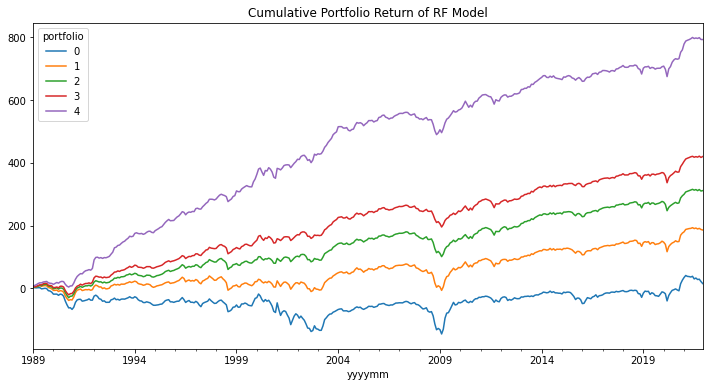

In [32]:
# plot the cumsum of the 5 portfolios
rf_portfolio.cumsum().plot(figsize=(12,6), title='Cumulative Portfolio Return of RF Model')

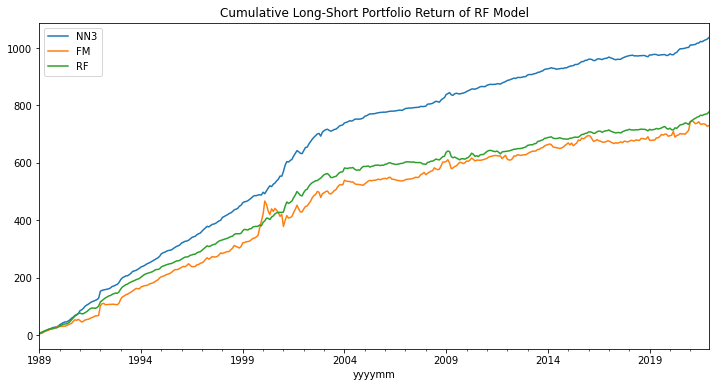

In [33]:
# calculate long-short portfolio return
import matplotlib.pyplot as plt
nn_portfolio['long_short'] = nn_portfolio[4] - nn_portfolio[0]
nn_portfolio['long_short'].cumsum().plot(figsize=(12,6), title='Cumulative Long-Short Portfolio Return of NN3 Model',label='NN3')
fm_portfolio['long_short'] = fm_portfolio[4] - fm_portfolio[0]
fm_portfolio['long_short'].cumsum().plot(figsize=(12,6), title='Cumulative Long-Short Portfolio Return of FM3 Model',label ='FM')
rf_portfolio['long_short'] = rf_portfolio[4] - rf_portfolio[0]
rf_portfolio['long_short'].cumsum().plot(figsize=(12,6), title='Cumulative Long-Short Portfolio Return of RF Model', label='RF')
plt.legend()

In [34]:
longshort = pd.DataFrame([nn_portfolio['long_short'], rf_portfolio['long_short'], fm_portfolio['long_short']]).T
longshort.columns = ['NN3', 'RF', 'FM']
apply_newey_west_t_stat(longshort).round(3)

,NN3,RF,FM
Mean,2.618,1.963,1.844
Standard Error,0.343,0.291,0.318
T-statistic,7.640,6.754,5.796
P-value,0.000,0.000,0.000
SR,2.635,1.853,0.938
